# Part 1 - Text Processing and Exploratory Data Analysis

<b>Group Members:</b>
<p>Guillem Gauchia Torres - u186410 - 240215</p>
<p>Àlex Herrero Díaz - u186402 - 240799</p>
<p>Adrià Julià Parada - u188319 - 242195</p>
<p><b>Date: </b> 21/10/2023</p>

# 1. Document Pre-process

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Python Packages

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import TweetTokenizer
import math
import csv
import numpy as np
import collections
import json
import string
import re
from numpy import linalg as la

#### Load Data

#### Functions to pre-process the data

In [127]:
def split_hashtag_words(text):
  tokens = re.findall(r'\w+|#\w+', text)

  result_tokens = []

  for token in tokens:
      if token.startswith('#'):
          # Remove the '#' symbol and split the hashtag into words by uppercase letters
          hashtag = token[1:]
          hashtag_words = re.findall(r'[A-Z][a-z]*', hashtag)

          # Check if all words in the hashtag are in uppercase, then treat it as a single word
          if all(word.isupper() for word in hashtag_words):
              result_tokens.append(hashtag)
          else:
              result_tokens.extend(hashtag_words)
      else:
          result_tokens.append(token)

  return result_tokens

In [106]:
def build_terms(line):
    """
    Preprocess the text by removing stop words, stemming,
    transforming to lowercase, and returning the tokens of the text.

    Arguments:
    line -- string (text) to be preprocessed

    Returns:
    terms -- a list of tokens corresponding to the input text after preprocessing
    """
    # Remove URLs
    line = re.sub(r'http\S+', '', line)

    temp_terms = split_hashtag_words(line)
    line = " ".join(temp_terms)

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Transform to lowercase
    line = line.lower()

    # Remove punctuation, emojis, symbols, numbers, and strings starting with '#' and '@'
    line = re.sub(r'@\w+', '', line)
    line = re.sub(r'#\w+', '', line)
    line = re.sub(r'[^\w\s]', '', line)
    line = re.sub(r'[\d]', '', line)

    # Tokenize the text to get a list of terms
    # Initialize the TweetTokenizer
    tokenizer = TweetTokenizer()

    # Tokenize the tweet into words
    terms = split_hashtag_words(line)

    # Remove stopwords and perform stemming
    terms = [stemmer.stem(word) for word in terms if word not in stop_words]

    # Join the words back into a sentence
    line = " ".join(terms)

    return terms, line

# Example usage
text_example = "Sample text with #RussianUkraineWar #UN and https://example.com. 😊"
terms_example, text = build_terms(text_example)
print("Original text:", text_example)
print("Preprocessed terms: ", terms_example)
print("Processed line: ", text)

Original text: Sample text with #RussianUkraineWar #UN and https://example.com. 😊
Preprocessed terms:  ['sampl', 'text', 'russian', 'ukrain', 'war', 'un']
Processed line:  sampl text russian ukrain war un


In [107]:
# Function to obtain document ids for each tweet
def get_data_ids(file_path):
  id_to_doc = defaultdict(list)

  with open(file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')

    for row in csv_reader:
      id_to_doc[row[1]] = row[0]
  return id_to_doc

file_path = '/content/drive/Shareddrives/RIAW/IRWA Project summary and first deliverable-20231010/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'

data_ids = get_data_ids(file_path)


#### Create the dictionary

In [110]:
def create_dictionary(file_path):
  dictionary = defaultdict(list)

  # Base URL for tweets
  base_tweet_url = "https://twitter.com/twitter_username/status/"

  # Read the JSON file line by line and process each tweet
  with open(file_path, 'r') as file:
      for line in file:
        # Read data
        tweet_data = json.loads(line)
        created_at = tweet_data['created_at']
        full_text = tweet_data['full_text']
        hashtags = [hashtag['text'] for hashtag in tweet_data['entities']['hashtags']]
        tweet_id_str = tweet_data['id_str']  # Tweet ID to construct tweet URL
        tweet_id = tweet_data['id']
        likes = tweet_data['favorite_count']
        retweets = tweet_data['retweet_count']
        terms, _ = build_terms(full_text)

        # Construct the tweet URL
        tweet_url = base_tweet_url + tweet_id_str

        # Store into dictionary
        dictionary['Tweet'].append(full_text)
        dictionary['Id'].append(tweet_data['id'])
        dictionary['Date'].append(created_at)
        dictionary['Hashtags'].append(hashtags)
        dictionary['Likes'].append(int(likes))
        dictionary['Retweets'].append(int(retweets))
        dictionary['Url'].append(tweet_url)
        dictionary['Doc'].append(data_ids[tweet_id_str])
        dictionary['Tokens'].append(terms)

  return dictionary


In [111]:
import time

file_path = '/content/drive/Shareddrives/RIAW/IRWA Project summary and first deliverable-20231010/IRWA_data_2023/Rus_Ukr_war_data.json'
# Monitorize execution time
start_time = time.time()
# Creation of the dictionary
dictionary = create_dictionary(file_path)
print("Total time to create the Dictionary: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the Dictionary: 5.15 seconds


In [125]:
# Example of an element from the dictionary
element = 2118
print("Tweet: {}\nId: {}\nDate: {}\nHashtags: {}\nLikes: {}\nRetweets: {}\nUrl: {}\nDoc: {}\nTokens: {}".format(dictionary['Tweet'][element],dictionary['Id'][element], dictionary['Date'][element], dictionary['Hashtags'][element], dictionary['Likes'][element], dictionary['Retweets'][element], dictionary['Url'][element], dictionary['Doc'][element], dictionary['Tokens'][element]))

Tweet: 🗞️Kostyantyn Nemichev, the commander of Kraken Special Unit, recently revelated that Kraken has more than 1500 people and is size of regiment. That makes it currently one of the largest Ukrainian unit formed by volunteers.
#UkraineRussiaWar https://t.co/vpQcmL92q7
Id: 1575559188079845376
Date: Thu Sep 29 18:52:37 +0000 2022
Hashtags: ['UkraineRussiaWar']
Likes: 1407
Retweets: 136
Url: https://twitter.com/twitter_username/status/1575559188079845376
Doc: doc_2119
Tokens: ['kostyantyn', 'nemichev', 'command', 'kraken', 'special', 'unit', 'recent', 'revel', 'kraken', 'peopl', 'size', 'regiment', 'make', 'current', 'one', 'largest', 'ukrainian', 'unit', 'form', 'volunt', 'ukrain', 'russia', 'war']


## 2. Exploratory Data Analysis

#### Vocabulary size

In [118]:
# Find vocabulary size
vocabulary = set()
for tokens in dictionary['Tokens']:
  vocabulary.update(tokens)
print("In the {} Tweets the vocabulary size is of {} stemmed words".format(len(dictionary['Id']), len(vocabulary)))

In the 4000 Tweets the vocabulary size is of 7189 stemmed words


#### Average tokens length

In [117]:
#Find the average tokens length for the entire dataset
total_tokens = 0
for tokens in dictionary['Tokens']:
  for token in tokens:
    total_tokens +=1

average_sentence_length = total_tokens / len(dictionary['Tweet'])
print(f'The average token length is of {average_sentence_length} tokens')

The average token length is of 21.33175 tokens


#### Top stemmed 10 words with more occurrences

In [98]:
sorted_dict_by_occurences = dict(sorted(index.items(), key=lambda item: len(item[1]), reverse=True))
# Print the first 10 entries
print("Top stemmed 10 words with more occurrences in the data:")
count = 0
for key, value in sorted_dict_by_occurences.items():
    if count >= 10:
        break
    print(f'   #{count+1} {key} - {len(index[key])}')

    count += 1

Top stemmed 10 words with more occurrences in the data:
   #1 ukrain - 3989
   #2 russia - 3947
   #3 war - 3928
   #4 russian - 1590
   #5 putin - 1126
   #6 ukrainian - 1051
   #7 armi - 552
   #8 nato - 543
   #9 kherson - 501
   #10 state - 496


#### Top 10 most liked Tweets

In [99]:
# Get the indices that correspond to the sorted 'Likes' values
sorted_indices = sorted(range(len(dictionary['Likes'])), key=lambda k: dictionary['Likes'][k], reverse=True)

# Initialize a new dictionary to store the sorted values
sorted_dictionary_by_likes = {key: [dictionary[key][i] for i in sorted_indices] for key in dictionary}

# Print the sorted dictionary
print("Top 10 most liked Tweets:")
for i in range(10):
  print('   #{} Tweet: {} has {} likes'.format(i+1, sorted_dictionary_by_likes['Doc'][i], sorted_dictionary_by_likes['Likes'][i]))

Top 10 most liked Tweets:
   #1 Tweet: doc_1220 has 3701 likes
   #2 Tweet: doc_2814 has 2685 likes
   #3 Tweet: doc_3766 has 2155 likes
   #4 Tweet: doc_2824 has 1631 likes
   #5 Tweet: doc_206 has 1407 likes
   #6 Tweet: doc_2119 has 1407 likes
   #7 Tweet: doc_3802 has 1348 likes
   #8 Tweet: doc_451 has 1083 likes
   #9 Tweet: doc_1847 has 923 likes
   #10 Tweet: doc_1245 has 868 likes


#### Top 10 most retweeted Tweets

In [126]:
# Get the indices that correspond to the sorted 'Likes' values
sorted_indices = sorted(range(len(dictionary['Retweets'])), key=lambda k: dictionary['Retweets'][k], reverse=True)

# Initialize a new dictionary to store the sorted values
sorted_dictionary_by_retweets = {key: [dictionary[key][i] for i in sorted_indices] for key in dictionary}

# Print the sorted dictionary
print("Top 10 most retweeted Tweets:")
for i in range(10):
  print('   #{} Tweet: {} has {} retweets'.format(i+1, sorted_dictionary_by_retweets['Doc'][i], sorted_dictionary_by_retweets['Retweets'][i]))

Top 10 most retweeted Tweets:
   #1 Tweet: doc_1220 has 646 retweets
   #2 Tweet: doc_2814 has 338 retweets
   #3 Tweet: doc_3766 has 283 retweets
   #4 Tweet: doc_1847 has 251 retweets
   #5 Tweet: doc_1388 has 247 retweets
   #6 Tweet: doc_1210 has 236 retweets
   #7 Tweet: doc_1533 has 184 retweets
   #8 Tweet: doc_206 has 171 retweets
   #9 Tweet: doc_2119 has 136 retweets
   #10 Tweet: doc_3802 has 133 retweets


#### WordCloud with most frequent tokens

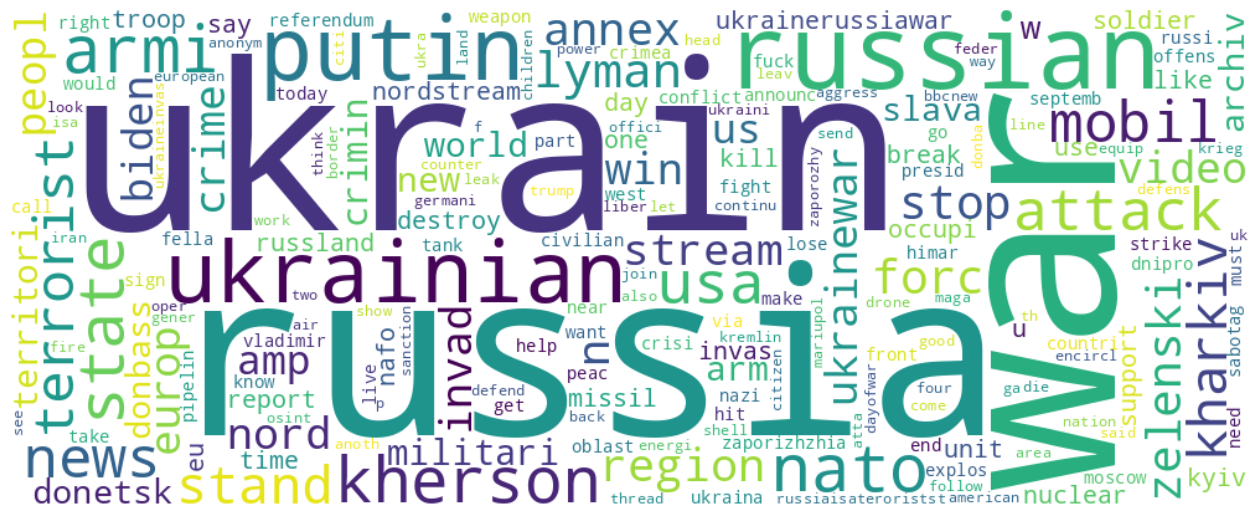

In [102]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the list with the words and the occurences
keyword_occurences = []
for key, value in sorted_dict_by_occurences.items():
  keyword_occurences.append([key,len(index[key])])


# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Usage of spaCy NLP model to extract Top 10 most frequent entities and types

In [103]:
import spacy
from collections import Counter

# Load the spaCy NLP model (you need to download and install the model first)
nlp = spacy.load('en_core_web_sm')

# Function to perform entity recognition on a single tweet
def perform_entity_recognition(tweet):
    doc = nlp(tweet)
    entities = [{'text': ent.text, 'type': ent.label_} for ent in doc.ents]
    return entities

# Process each tweet and perform entity recognition
all_entities = []
for i in range(4000):
    _, tweet = build_terms(dictionary['Tweet'][i])
    entities = perform_entity_recognition(tweet)
    all_entities.extend(entities)

# Count the frequency of each entity
entity_counts = Counter(item['text'] for item in all_entities)

# Sort entities by frequency in descending order
sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most frequent entities
print("Top 10 most frequent entities:")
for entity, count in sorted_entities[:10]:
    print(f"Entity: {entity}, Frequency: {count}")

# Count the frequency of each entity
type_counts = Counter(item['type'] for item in all_entities)

# Sort entities by frequency in descending order
sorted_entities_type = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most frequent entities
print("\nTop 10 most frequent types:")
for entity, count in sorted_entities_type[:10]:
    print(f"Type: {entity}, Frequency: {count}")

Top 10 most frequent entities:
Entity: russia, Frequency: 6623
Entity: russian, Frequency: 2205
Entity: armi, Frequency: 572
Entity: putin, Frequency: 448
Entity: nato, Frequency: 333
Entity: kherson, Frequency: 152
Entity: one, Frequency: 96
Entity: slava, Frequency: 91
Entity: moscow, Frequency: 90
Entity: nord, Frequency: 89

Top 10 most frequent types:
Type: GPE, Frequency: 7616
Type: PERSON, Frequency: 3418
Type: ORG, Frequency: 2697
Type: NORP, Frequency: 2539
Type: DATE, Frequency: 333
Type: CARDINAL, Frequency: 289
Type: LANGUAGE, Frequency: 107
Type: EVENT, Frequency: 95
Type: LOC, Frequency: 68
Type: ORDINAL, Frequency: 59
